# Co-DeepNet U-Net: Cooperative Learning for Medical Image Analysis

This notebook implements the Co-DeepNet architecture from "Co-DeepNet: A Cooperative Convolutional Neural Network" paper, adapted for medical image segmentation with tumor classification.

## Key Concepts:
- **Tag-Team Training**: Two U-Nets alternate active training periods
- **Knowledge Transmission**: Active network mentors inactive network
- **Dual Task**: Classification (tumor present?) + Segmentation (where is tumor?)
- **Cooperative Learning**: Networks explore different solution spaces while sharing discoveries

## Architecture Overview:
```
Input → [U-Net-A] ⟷ Knowledge Transfer ⟷ [U-Net-B] → Ensemble → {Classification, Segmentation}
         (active)                          (inactive)
                    ↓ Swap roles ↓
         (inactive)                         (active)
```

## 1. Setup & Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from typing import Tuple

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. U-Net Architecture with Classification Head

Each U-Net outputs:
1. **Segmentation mask**: Pixel-level tumor localization
2. **Classification logits**: Binary tumor presence prediction

In [2]:
class DoubleConv(nn.Module):
    """(Conv2d → BatchNorm → ReLU) × 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class UNetWithClassifier(nn.Module):
    """
    U-Net architecture with dual output:
    - Segmentation: Pixel-level tumor mask
    - Classification: Binary tumor presence
    """
    def __init__(self, in_channels=1, seg_classes=1, network_id='A'):
        super().__init__()
        self.network_id = network_id
        
        # Encoder (Contracting Path)
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        
        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)
        
        # Classification Head (from bottleneck features)
        self.clf_pool = nn.AdaptiveAvgPool2d(1)
        self.clf_fc = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 1)  # Binary classification
        )
        
        # Decoder (Expanding Path)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)
        
        # Segmentation Output
        self.seg_out = nn.Conv2d(64, seg_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        enc4 = self.enc4(self.pool3(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool4(enc4))
        
        # Classification Branch
        clf_features = self.clf_pool(bottleneck)
        clf_features = clf_features.view(clf_features.size(0), -1)
        clf_logits = self.clf_fc(clf_features)
        
        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.dec4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.dec1(dec1)
        
        # Segmentation Output
        seg_logits = self.seg_out(dec1)
        
        return seg_logits, clf_logits
    
    def get_encoder_params(self):
        """Get encoder parameters for knowledge transfer"""
        return list(self.enc1.parameters()) + list(self.enc2.parameters()) + \
               list(self.enc3.parameters()) + list(self.enc4.parameters())
    
    def get_decoder_params(self):
        """Get decoder parameters"""
        return list(self.dec1.parameters()) + list(self.dec2.parameters()) + \
               list(self.dec3.parameters()) + list(self.dec4.parameters())
    
    def get_bottleneck_params(self):
        """Get bottleneck parameters"""
        return list(self.bottleneck.parameters())

## 3. Knowledge Transmission Module

Implements the mentoring mechanism where the active network transfers learned knowledge to the inactive network.

**Transmission Strategies:**
- `encoder_only`: Transfer early feature extractors (like Co-DeepNet paper)
- `full_network`: Transfer all parameters
- `bottleneck_only`: Transfer only the deepest representations

In [3]:
class KnowledgeTransmitter:
    """
    Implements knowledge transmission from active to inactive network.
    
    Based on Co-DeepNet paper: the active network mentors the inactive one,
    allowing the inactive network to benefit from discoveries without training.
    """
    def __init__(self, transmission_rate=0.3, strategy='encoder_only'):
        """
        Args:
            transmission_rate: Weight for knowledge transfer (0.3 = 30% from active, 70% keep own)
            strategy: 'encoder_only', 'full_network', or 'bottleneck_only'
        """
        self.transmission_rate = transmission_rate
        self.strategy = strategy
        self.transmission_count = 0
    
    def transmit(self, active_net: UNetWithClassifier, inactive_net: UNetWithClassifier):
        """
        Transfer knowledge from active to inactive network.
        
        Formula: θ_inactive = (1-α) * θ_inactive + α * θ_active
        where α is the transmission_rate
        """
        self.transmission_count += 1
        alpha = self.transmission_rate
        
        # Select parameters based on strategy
        if self.strategy == 'encoder_only':
            active_params = active_net.get_encoder_params()
            inactive_params = inactive_net.get_encoder_params()
        elif self.strategy == 'bottleneck_only':
            active_params = active_net.get_bottleneck_params()
            inactive_params = inactive_net.get_bottleneck_params()
        elif self.strategy == 'full_network':
            active_params = list(active_net.parameters())
            inactive_params = list(inactive_net.parameters())
        else:
            raise ValueError(f"Unknown strategy: {self.strategy}")
        
        # Transfer knowledge with EMA-like update
        with torch.no_grad():
            for inactive_param, active_param in zip(inactive_params, active_params):
                # Inactive retains most of its knowledge but learns from active
                inactive_param.data = (1 - alpha) * inactive_param.data + alpha * active_param.data
        
        return {
            'transmission_id': self.transmission_count,
            'strategy': self.strategy,
            'rate': alpha,
            'params_transferred': len(list(active_params))
        }

## 4. Co-DeepNet Training Manager

Implements the tag-team training strategy:
1. **One network trains** while the other rests
2. **Periodic knowledge transmission** from active to inactive
3. **Role swap** at specified intervals
4. **Ensemble prediction** for final output

In [4]:
class CoDeepNetTrainer:
    """
    Manages cooperative training of two U-Nets following Co-DeepNet principles.
    
    Key mechanisms:
    - Tag-team: Only one network trains at a time
    - Knowledge transmission: Active mentors inactive periodically
    - Role swapping: Networks alternate being active
    - Ensemble: Average both outputs for final prediction
    """
    def __init__(
        self,
        unet_a: UNetWithClassifier,
        unet_b: UNetWithClassifier,
        optimizer_a: torch.optim.Optimizer,
        optimizer_b: torch.optim.Optimizer,
        swap_frequency: int = 50,  # Swap roles every N batches
        transmission_frequency: int = 10,  # Transmit knowledge every N batches
        transmission_rate: float = 0.3,
        transmission_strategy: str = 'encoder_only',
        seg_weight: float = 1.0,
        clf_weight: float = 0.5,
        device: str = 'cuda'
    ):
        self.unet_a = unet_a.to(device)
        self.unet_b = unet_b.to(device)
        self.optimizer_a = optimizer_a
        self.optimizer_b = optimizer_b
        
        self.swap_frequency = swap_frequency
        self.transmission_frequency = transmission_frequency
        self.seg_weight = seg_weight
        self.clf_weight = clf_weight
        self.device = device
        
        # Knowledge transmitter
        self.transmitter = KnowledgeTransmitter(
            transmission_rate=transmission_rate,
            strategy=transmission_strategy
        )
        
        # Training state
        self.active_network = 'A'  # Start with network A
        self.batch_count = 0
        self.swap_count = 0
        
        # Loss functions
        self.seg_criterion = nn.BCEWithLogitsLoss()
        self.clf_criterion = nn.BCEWithLogitsLoss()
        
        # Metrics tracking
        self.history = {
            'network_a': {'total_loss': [], 'seg_loss': [], 'clf_loss': []},
            'network_b': {'total_loss': [], 'seg_loss': [], 'clf_loss': []},
            'active_network': [],
            'transmissions': []
        }
    
    def _compute_loss(
        self, 
        seg_logits: torch.Tensor, 
        clf_logits: torch.Tensor,
        seg_target: torch.Tensor,
        clf_target: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Compute combined segmentation + classification loss"""
        seg_loss = self.seg_criterion(seg_logits, seg_target)
        clf_loss = self.clf_criterion(clf_logits.squeeze(), clf_target.float())
        
        total_loss = self.seg_weight * seg_loss + self.clf_weight * clf_loss
        return total_loss, seg_loss, clf_loss
    
    def train_step(self, images: torch.Tensor, seg_masks: torch.Tensor, clf_labels: torch.Tensor):
        """
        Single training step following Co-DeepNet protocol.
        
        Returns:
            Dictionary with losses and metadata
        """
        self.batch_count += 1
        images = images.to(self.device)
        seg_masks = seg_masks.to(self.device)
        clf_labels = clf_labels.to(self.device)
        
        # Determine active network
        if self.active_network == 'A':
            active_net = self.unet_a
            active_optimizer = self.optimizer_a
            inactive_net = self.unet_b
        else:
            active_net = self.unet_b
            active_optimizer = self.optimizer_b
            inactive_net = self.unet_a
        
        # Train ONLY active network (tag-team principle)
        active_net.train()
        inactive_net.eval()  # Inactive network rests
        
        active_optimizer.zero_grad()
        
        # Forward pass (active network only)
        seg_logits, clf_logits = active_net(images)
        
        # Compute loss
        total_loss, seg_loss, clf_loss = self._compute_loss(
            seg_logits, clf_logits, seg_masks, clf_labels
        )
        
        # Backward pass
        total_loss.backward()
        active_optimizer.step()
        
        # Knowledge transmission (periodic mentoring)
        transmission_info = None
        if self.batch_count % self.transmission_frequency == 0:
            transmission_info = self.transmitter.transmit(active_net, inactive_net)
            self.history['transmissions'].append({
                'batch': self.batch_count,
                'from': self.active_network,
                'info': transmission_info
            })
        
        # Role swap (tag-team rotation)
        swapped = False
        if self.batch_count % self.swap_frequency == 0:
            self.active_network = 'B' if self.active_network == 'A' else 'A'
            self.swap_count += 1
            swapped = True
        
        # Record metrics
        net_key = 'network_a' if self.active_network == 'A' else 'network_b'
        self.history[net_key]['total_loss'].append(total_loss.item())
        self.history[net_key]['seg_loss'].append(seg_loss.item())
        self.history[net_key]['clf_loss'].append(clf_loss.item())
        self.history['active_network'].append(self.active_network)
        
        return {
            'total_loss': total_loss.item(),
            'seg_loss': seg_loss.item(),
            'clf_loss': clf_loss.item(),
            'active_network': self.active_network,
            'swapped': swapped,
            'transmission': transmission_info is not None
        }
    
    def predict_ensemble(self, images: torch.Tensor):
        """
        Ensemble prediction: Average outputs from both networks.
        
        This is the key benefit of cooperative learning - two networks
        that explored different solution spaces combine their knowledge.
        """
        self.unet_a.eval()
        self.unet_b.eval()
        
        with torch.no_grad():
            images = images.to(self.device)
            
            # Get predictions from both networks
            seg_a, clf_a = self.unet_a(images)
            seg_b, clf_b = self.unet_b(images)
            
            # Ensemble: Average logits
            seg_ensemble = (seg_a + seg_b) / 2
            clf_ensemble = (clf_a + clf_b) / 2
            
            # Apply sigmoid for probabilities
            seg_probs = torch.sigmoid(seg_ensemble)
            clf_probs = torch.sigmoid(clf_ensemble)
        
        return seg_probs, clf_probs, (seg_a, clf_a), (seg_b, clf_b)
    
    def get_training_summary(self):
        """Get summary of training dynamics"""
        return {
            'total_batches': self.batch_count,
            'total_swaps': self.swap_count,
            'total_transmissions': self.transmitter.transmission_count,
            'final_active': self.active_network,
            'avg_loss_a': np.mean(self.history['network_a']['total_loss'][-100:]) if self.history['network_a']['total_loss'] else 0,
            'avg_loss_b': np.mean(self.history['network_b']['total_loss'][-100:]) if self.history['network_b']['total_loss'] else 0
        }

## 5. Dataset & DataLoader

## 5a. Data Directory Explorer

In [5]:
# Find the correct data directory
import os

# Get current working directory
cwd = Path.cwd()
print(f"Current working directory: {cwd}")

# Project root (should be DeepLearning-MiniProject)
project_root = Path('/Users/idahayjorgensen/Documents/cs/deep_learning/DeepLearning-MiniProject')
print(f"\nProject root: {project_root}")
print(f"Project root exists: {project_root.exists()}")

# Check for augmented_data
augmented_data_path = project_root / 'augmented_data'
print(f"\nAugmented data path: {augmented_data_path}")
print(f"Augmented data exists: {augmented_data_path.exists()}")

if augmented_data_path.exists():
    print("\n📂 Directory structure:")
    for item in sorted(augmented_data_path.rglob('*'))[:20]:  # Show first 20 items
        relative = item.relative_to(augmented_data_path)
        if item.is_dir():
            print(f"  📁 {relative}/")
        else:
            print(f"  📄 {relative}")
    
    # Count files
    control_imgs = list((augmented_data_path / 'controls' / 'imgs').glob('*.*')) if (augmented_data_path / 'controls' / 'imgs').exists() else []
    patient_imgs = list((augmented_data_path / 'patients' / 'imgs').glob('*.*')) if (augmented_data_path / 'patients' / 'imgs').exists() else []
    patient_labels = list((augmented_data_path / 'patients' / 'labels').glob('*.*')) if (augmented_data_path / 'patients' / 'labels').exists() else []
    
    print(f"\n📊 File counts:")
    print(f"  Controls: {len(control_imgs)}")
    print(f"  Patient images: {len(patient_imgs)}")
    print(f"  Patient labels: {len(patient_labels)}")
    
    # Show sample filenames
    if control_imgs:
        print(f"\n  Sample control files: {[f.name for f in control_imgs[:3]]}")
    if patient_imgs:
        print(f"  Sample patient files: {[f.name for f in patient_imgs[:3]]}")
    if patient_labels:
        print(f"  Sample label files: {[f.name for f in patient_labels[:3]]}")
else:
    print("\n⚠️ Augmented data directory not found!")
    print("Searching for it...")
    
    # Search for augmented_data in common locations
    search_paths = [
        project_root / 'augmented_data',
        project_root / 'data' / 'augmented_data',
        project_root / 'Notebooks' / 'augmented_data',
        Path.cwd() / 'augmented_data',
    ]
    
    for search_path in search_paths:
        print(f"  Checking: {search_path} ... {search_path.exists()}")
        if search_path.exists():
            print(f"  ✓ Found it!")
            break

Current working directory: /work/IdaHayJørgensen#9284/Notebooks

Project root: /Users/idahayjorgensen/Documents/cs/deep_learning/DeepLearning-MiniProject
Project root exists: False

Augmented data path: /Users/idahayjorgensen/Documents/cs/deep_learning/DeepLearning-MiniProject/augmented_data
Augmented data exists: False

⚠️ Augmented data directory not found!
Searching for it...
  Checking: /Users/idahayjorgensen/Documents/cs/deep_learning/DeepLearning-MiniProject/augmented_data ... False
  Checking: /Users/idahayjorgensen/Documents/cs/deep_learning/DeepLearning-MiniProject/data/augmented_data ... False
  Checking: /Users/idahayjorgensen/Documents/cs/deep_learning/DeepLearning-MiniProject/Notebooks/augmented_data ... False
  Checking: /work/IdaHayJørgensen#9284/Notebooks/augmented_data ... True
  ✓ Found it!


## 5b. Load Augmented Dataset 🎯

### ✅ Your Augmented Data is Ready!

From your EDA notebook, you created an augmented dataset with:
- **Controls**: ~426 images (healthy, no tumors)
- **Patients**: ~182 × 5 = ~910 images (with augmentations: original + horizontal_flip + vertical_flip + rotate_90 + rotate_180)
- **Total**: ~1,336 images with proper class balance!

The augmented data is located at:
```
/Users/idahayjorgensen/Documents/cs/deep_learning/DeepLearning-MiniProject/augmented_data/
├── controls/imgs/          # .png files
└── patients/
    ├── imgs/               # patient_XXX_augtype.png
    └── labels/             # segmentation_XXX_augtype.png
```

The cell below will:
1. Auto-detect the correct data path (prioritizes local augmented data)
2. Smart matching: `patient_000_horizontal_flip.png` → `segmentation_000_horizontal_flip.png`
3. Load BOTH controls and patients for proper training

In [6]:
from PIL import Image

class TumorSegmentationDataset(Dataset):
    """Dataset for MIP-PET tumor images with segmentation masks and classification labels"""
    def __init__(self, data_dir: str, split='train', include_controls=True, include_patients=True):
        self.data_dir = Path(data_dir)
        
        print(f"Loading dataset from: {self.data_dir}")
        print(f"Directory exists: {self.data_dir.exists()}")
        
        self.samples = []
        
        # ===== LOAD CONTROLS (no tumor) =====
        if include_controls:
            control_dir = self.data_dir / 'controls' / 'imgs'
            print(f"\n📂 Looking for controls in: {control_dir}")
            print(f"   Control directory exists: {control_dir.exists()}")
            
            if control_dir.exists():
                # Look for .png files
                self.control_files = sorted(list(control_dir.glob('*.png')))
                print(f"   Found {len(self.control_files)} control PNG files")
                if self.control_files:
                    print(f"   Sample: {[f.name for f in self.control_files[:3]]}")
                
                # Add controls (no segmentation mask, just zeros)
                for img_path in self.control_files:
                    self.samples.append((img_path, None, 0))  # 0 = no tumor
            else:
                self.control_files = []
                print(f"   ⚠️ Control directory not found!")
        else:
            self.control_files = []
            print(f"\n⏭️  Skipping controls (include_controls=False)")
        
        # ===== LOAD PATIENTS (with tumors) =====
        if include_patients:
            patient_img_dir = self.data_dir / 'patients' / 'imgs'
            patient_label_dir = self.data_dir / 'patients' / 'labels'
            
            print(f"\n📂 Looking for patients in: {patient_img_dir}")
            print(f"   Patient directory exists: {patient_img_dir.exists()}")
            print(f"   Label directory exists: {patient_label_dir.exists()}")
            
            if patient_img_dir.exists():
                # Look for .png files
                self.patient_files = sorted(list(patient_img_dir.glob('*.png')))
                print(f"   Found {len(self.patient_files)} patient PNG files")
                
                if self.patient_files:
                    print(f"   Sample: {[f.name for f in self.patient_files[:3]]}")
                
                # Add patients (with segmentation masks)
                missing_labels = []
                found_labels = 0
                
                for img_path in self.patient_files:
                    # Smart label matching: patient_XXX_augtype.png → segmentation_XXX_augtype.png
                    img_stem = img_path.stem  # e.g., "patient_000_horizontal_flip"
                    
                    # Try multiple label naming patterns (PNG)
                    possible_label_names = [
                        img_path.name,  # Same name (patient_XXX.png)
                        img_stem + '.png',  # Same stem with .png
                        img_stem.replace('patient_', 'segmentation_') + '.png',
                    ]
                    
                    label_path = None
                    for label_name in possible_label_names:
                        test_path = patient_label_dir / label_name
                        if test_path.exists():
                            label_path = test_path
                            break
                    
                    if label_path:
                        self.samples.append((img_path, label_path, 1))  # 1 = tumor present
                        found_labels += 1
                    else:
                        missing_labels.append(img_path.name)
                
                print(f"   ✓ Matched {found_labels} patient images with labels")
                
                if missing_labels:
                    print(f"   ⚠️ Warning: {len(missing_labels)} patient images missing labels")
                    if len(missing_labels) <= 5:
                        print(f"   Missing labels for: {missing_labels}")
            else:
                self.patient_files = []
                print(f"   ⚠️ Patient directory not found!")
        else:
            self.patient_files = []
            print(f"\n⏭️  Skipping patients (include_patients=False)")
        
        # ===== SUMMARY =====
        num_controls = len([s for s in self.samples if s[2] == 0])
        num_patients = len([s for s in self.samples if s[2] == 1])
        
        print(f"\n{'='*60}")
        print(f"📊 DATASET SUMMARY")
        print(f"{'='*60}")
        print(f"   Controls (no tumor):  {num_controls} samples")
        print(f"   Patients (w/ tumor):  {num_patients} samples")
        print(f"   Total samples:        {len(self.samples)} samples")
        print(f"   Class balance:        {num_patients}/{num_controls+num_patients} = {num_patients/(num_controls+num_patients)*100:.1f}% positive")
        print(f"{'='*60}\n")
        
        if len(self.samples) == 0:
            print("\n❌ ERROR: No samples found!")
            print(f"Please check that PNG image files exist in:")
            print(f"  - {self.data_dir / 'controls' / 'imgs'}")
            print(f"  - {self.data_dir / 'patients' / 'imgs'}")
            raise ValueError(f"No PNG data found in {self.data_dir}. Please check directory structure.")
        
        if num_patients == 0:
            print("\n⚠️  WARNING: No patient samples with tumors found!")
            print("   The model will not learn to detect tumors.")
            print("   Check that patient images and labels are in the correct directory.")
    
    def __len__(self):
        return len(self.samples)
    
    def _load_image(self, path: Path) -> np.ndarray:
        """Load PNG image and convert to grayscale numpy array"""
        img = Image.open(path).convert('L')
        return np.array(img)
    
    def __getitem__(self, idx):
        img_path, label_path, has_tumor = self.samples[idx]
        
        # Load image (PNG)
        image = self._load_image(img_path)
        
        # Normalize to [0, 1]
        if image.max() > 1.0:
            image = image / 255.0
        
        # Load segmentation mask (or create empty for controls)
        if label_path and label_path.exists():
            mask = self._load_image(label_path)
            if mask.max() > 1.0:
                mask = mask / 255.0
        else:
            mask = np.zeros_like(image)
        
        # Add channel dimension if needed
        if image.ndim == 2:
            image = image[np.newaxis, ...]
        if mask.ndim == 2:
            mask = mask[np.newaxis, ...]
        
        # Convert to tensors
        image = torch.from_numpy(image).float()
        mask = torch.from_numpy(mask).float()
        clf_label = torch.tensor(has_tumor, dtype=torch.long)
        
        return image, mask, clf_label


# ============================================================
# Create Dataset - Try Multiple Possible Paths
# ============================================================
print("="*70)
print("🔍 INITIALIZING MIP-PET TUMOR SEGMENTATION DATASET")
print("="*70)

# Try different possible data paths (prioritize local augmented data!)
possible_paths = [
    Path('/Users/idahayjorgensen/Documents/cs/deep_learning/DeepLearning-MiniProject/augmented_data'),  # local augmented
    Path('/Users/idahayjorgensen/Documents/cs/deep_learning/DeepLearning-MiniProject/data'),  # Local original
    Path('/work/IdaHayJørgensen#9284/Notebooks/augmented_data'),  # Virtual env augmented
    Path('/work/IdaHayJørgensen#9284/Notebooks/data'),  # Virtual env original
]

DATA_DIR = None
for path in possible_paths:
    print(f"\n🔍 Checking: {path}")
    if path.exists():
        # Check if it has the right structure
        has_controls = (path / 'controls' / 'imgs').exists()
        has_patients = (path / 'patients' / 'imgs').exists()
        
        print(f"   Controls found: {has_controls}")
        print(f"   Patients found: {has_patients}")
        
        if has_controls or has_patients:
            DATA_DIR = path
            print(f"   ✅ Using this directory!")
            break
    else:
        print(f"   ❌ Directory doesn't exist")

if DATA_DIR is None:
    print("\n❌ ERROR: Could not find data directory!")
    print("\nPlease verify your data is in one of these locations:")
    for path in possible_paths:
        print(f"  • {path}")
    raise FileNotFoundError("Data directory not found")

print(f"\n{'='*70}")
print(f"📂 Final data directory: {DATA_DIR}")
print(f"{'='*70}\n")

# Create dataset with BOTH controls and patients
train_dataset = TumorSegmentationDataset(
    str(DATA_DIR),
    include_controls=True,  # Include healthy controls (no tumors)
    include_patients=True   # Include patients with tumors
)

# Create dataloaders only if we have data
if len(train_dataset) > 0:
    train_loader = DataLoader(
        train_dataset,
        batch_size=8,
        shuffle=True,
        num_workers=0
    )
    print(f"✓ Training batches: {len(train_loader)}")
    print(f"✓ Batch size: 8")
    print(f"✓ Total samples per epoch: {len(train_dataset)}")
    
    # Show class distribution in first batch
    first_batch = next(iter(train_loader))
    images, masks, labels = first_batch
    print(f"\n📊 First batch statistics:")
    print(f"   Image shape: {images.shape}")
    print(f"   Mask shape: {masks.shape}")
    print(f"   Labels: {labels.tolist()} (0=no tumor, 1=tumor)")
    print(f"   Tumors in batch: {labels.sum().item()}/{len(labels)}")
else:
    print("\n⚠️ Cannot create DataLoader - no samples in dataset!")
    print("Please verify your data directory structure.")


🔍 INITIALIZING MIP-PET TUMOR SEGMENTATION DATASET

🔍 Checking: /Users/idahayjorgensen/Documents/cs/deep_learning/DeepLearning-MiniProject/augmented_data
   ❌ Directory doesn't exist

🔍 Checking: /Users/idahayjorgensen/Documents/cs/deep_learning/DeepLearning-MiniProject/data
   ❌ Directory doesn't exist

🔍 Checking: /work/IdaHayJørgensen#9284/Notebooks/augmented_data
   Controls found: True
   Patients found: True
   ✅ Using this directory!

📂 Final data directory: /work/IdaHayJørgensen#9284/Notebooks/augmented_data

Loading dataset from: /work/IdaHayJørgensen#9284/Notebooks/augmented_data
Directory exists: True

📂 Looking for controls in: /work/IdaHayJørgensen#9284/Notebooks/augmented_data/controls/imgs
   Control directory exists: True
   Found 426 control PNG files
   Sample: ['control_000.png', 'control_001.png', 'control_002.png']

📂 Looking for patients in: /work/IdaHayJørgensen#9284/Notebooks/augmented_data/patients/imgs
   Patient directory exists: True
   Label directory exists

## 6. Initialize Co-DeepNet System

In [7]:
# Initialize two U-Nets with different random initializations
# This ensures they explore different solution spaces
set_seed(42)
unet_a = UNetWithClassifier(in_channels=1, seg_classes=1, network_id='A')

set_seed(123)  # Different seed for diversity
unet_b = UNetWithClassifier(in_channels=1, seg_classes=1, network_id='B')

# Separate optimizers for each network
optimizer_a = torch.optim.Adam(unet_a.parameters(), lr=1e-4, weight_decay=1e-5)
optimizer_b = torch.optim.Adam(unet_b.parameters(), lr=1e-4, weight_decay=1e-5)

# Initialize Co-DeepNet trainer
codeepnet_trainer = CoDeepNetTrainer(
    unet_a=unet_a,
    unet_b=unet_b,
    optimizer_a=optimizer_a,
    optimizer_b=optimizer_b,
    swap_frequency=50,  # Swap active network every 50 batches
    transmission_frequency=10,  # Transmit knowledge every 10 batches
    transmission_rate=0.3,  # 30% from active, 70% keep own (like paper)
    transmission_strategy='encoder_only',  # Transfer early features
    seg_weight=1.0,
    clf_weight=0.5,
    device=device
)

print("\n✓ Co-DeepNet initialized with:")
print(f"  - Tag-team frequency: {codeepnet_trainer.swap_frequency} batches")
print(f"  - Knowledge transmission: every {codeepnet_trainer.transmission_frequency} batches")
print(f"  - Transmission rate: {codeepnet_trainer.transmitter.transmission_rate}")
print(f"  - Strategy: {codeepnet_trainer.transmitter.strategy}")


✓ Co-DeepNet initialized with:
  - Tag-team frequency: 50 batches
  - Knowledge transmission: every 10 batches
  - Transmission rate: 0.3
  - Strategy: encoder_only


## 7. Training Loop

This cell trains the Co-DeepNet model.

Implements the full Co-DeepNet training protocol:
- One network trains (active) while the other rests (inactive)
- Periodic knowledge transmission from active to inactive
- Regular role swaps to ensure both networks contribute

In [8]:
def train_epoch(trainer: CoDeepNetTrainer, dataloader: DataLoader, epoch: int):
    """Train for one epoch using Co-DeepNet protocol"""
    epoch_metrics = {
        'total_loss': [],
        'seg_loss': [],
        'clf_loss': [],
        'swaps': 0,
        'transmissions': 0
    }
    
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}")
    for images, masks, clf_labels in pbar:
        # Single training step (tag-team)
        metrics = trainer.train_step(images, masks, clf_labels)
        
        # Accumulate metrics
        epoch_metrics['total_loss'].append(metrics['total_loss'])
        epoch_metrics['seg_loss'].append(metrics['seg_loss'])
        epoch_metrics['clf_loss'].append(metrics['clf_loss'])
        if metrics['swapped']:
            epoch_metrics['swaps'] += 1
        if metrics['transmission']:
            epoch_metrics['transmissions'] += 1
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f"{metrics['total_loss']:.4f}",
            'active': metrics['active_network'],
            'swaps': epoch_metrics['swaps'],
            'tx': epoch_metrics['transmissions']
        })
    
    # Compute epoch averages
    return {
        'avg_total_loss': np.mean(epoch_metrics['total_loss']),
        'avg_seg_loss': np.mean(epoch_metrics['seg_loss']),
        'avg_clf_loss': np.mean(epoch_metrics['clf_loss']),
        'swaps': epoch_metrics['swaps'],
        'transmissions': epoch_metrics['transmissions']
    }


# Training configuration
NUM_EPOCHS = 20
training_history = []

print("\n🚀 Starting Co-DeepNet Training...\n")
print("Tag-team protocol:")
print("  → One network trains, one rests")
print("  → Active mentors inactive periodically")
print("  → Networks swap roles regularly\n")

for epoch in range(1, NUM_EPOCHS + 1):
    epoch_metrics = train_epoch(codeepnet_trainer, train_loader, epoch)
    training_history.append(epoch_metrics)
    
    print(f"\nEpoch {epoch}/{NUM_EPOCHS}:")
    print(f"  Total Loss: {epoch_metrics['avg_total_loss']:.4f}")
    print(f"  Seg Loss: {epoch_metrics['avg_seg_loss']:.4f}")
    print(f"  Clf Loss: {epoch_metrics['avg_clf_loss']:.4f}")
    print(f"  Network Swaps: {epoch_metrics['swaps']}")
    print(f"  Knowledge Transmissions: {epoch_metrics['transmissions']}")

# Training summary
summary = codeepnet_trainer.get_training_summary()
print("\n" + "="*60)
print("🎓 Training Complete!")
print("="*60)
print(f"Total batches processed: {summary['total_batches']}")
print(f"Total network swaps: {summary['total_swaps']}")
print(f"Total knowledge transmissions: {summary['total_transmissions']}")
print(f"Final active network: {summary['final_active']}")
print(f"Network A final loss: {summary['avg_loss_a']:.4f}")
print(f"Network B final loss: {summary['avg_loss_b']:.4f}")


🚀 Starting Co-DeepNet Training...

Tag-team protocol:
  → One network trains, one rests
  → Active mentors inactive periodically
  → Networks swap roles regularly



Epoch 1: 100%|██████████| 167/167 [00:42<00:00,  3.97it/s, loss=0.5350, active=B, swaps=3, tx=16]



Epoch 1/20:
  Total Loss: 0.5901
  Seg Loss: 0.3894
  Clf Loss: 0.4014
  Network Swaps: 3
  Knowledge Transmissions: 16


Epoch 2: 100%|██████████| 167/167 [00:42<00:00,  3.97it/s, loss=0.3855, active=A, swaps=3, tx=17]



Epoch 2/20:
  Total Loss: 0.4419
  Seg Loss: 0.2780
  Clf Loss: 0.3280
  Network Swaps: 3
  Knowledge Transmissions: 17


Epoch 3: 100%|██████████| 167/167 [00:41<00:00,  3.98it/s, loss=0.2277, active=A, swaps=4, tx=17]



Epoch 3/20:
  Total Loss: 0.3813
  Seg Loss: 0.2439
  Clf Loss: 0.2749
  Network Swaps: 4
  Knowledge Transmissions: 17


Epoch 4: 100%|██████████| 167/167 [00:40<00:00,  4.11it/s, loss=0.5454, active=B, swaps=3, tx=16]



Epoch 4/20:
  Total Loss: 0.3316
  Seg Loss: 0.1993
  Clf Loss: 0.2646
  Network Swaps: 3
  Knowledge Transmissions: 16


Epoch 5: 100%|██████████| 167/167 [00:40<00:00,  4.11it/s, loss=0.3687, active=A, swaps=3, tx=17]



Epoch 5/20:
  Total Loss: 0.3117
  Seg Loss: 0.1800
  Clf Loss: 0.2635
  Network Swaps: 3
  Knowledge Transmissions: 17


Epoch 6: 100%|██████████| 167/167 [00:41<00:00,  4.01it/s, loss=0.1729, active=A, swaps=4, tx=17]



Epoch 6/20:
  Total Loss: 0.2845
  Seg Loss: 0.1646
  Clf Loss: 0.2398
  Network Swaps: 4
  Knowledge Transmissions: 17


Epoch 7: 100%|██████████| 167/167 [00:40<00:00,  4.09it/s, loss=0.2718, active=B, swaps=3, tx=16]



Epoch 7/20:
  Total Loss: 0.2612
  Seg Loss: 0.1364
  Clf Loss: 0.2495
  Network Swaps: 3
  Knowledge Transmissions: 16


Epoch 8: 100%|██████████| 167/167 [00:40<00:00,  4.09it/s, loss=0.1240, active=A, swaps=3, tx=17]



Epoch 8/20:
  Total Loss: 0.2183
  Seg Loss: 0.1246
  Clf Loss: 0.1873
  Network Swaps: 3
  Knowledge Transmissions: 17


Epoch 9: 100%|██████████| 167/167 [00:40<00:00,  4.09it/s, loss=0.1100, active=A, swaps=4, tx=17]



Epoch 9/20:
  Total Loss: 0.2067
  Seg Loss: 0.1165
  Clf Loss: 0.1803
  Network Swaps: 4
  Knowledge Transmissions: 17


Epoch 10: 100%|██████████| 167/167 [00:41<00:00,  4.06it/s, loss=0.1320, active=B, swaps=3, tx=17]



Epoch 10/20:
  Total Loss: 0.1846
  Seg Loss: 0.0981
  Clf Loss: 0.1729
  Network Swaps: 3
  Knowledge Transmissions: 17


Epoch 11: 100%|██████████| 167/167 [00:41<00:00,  4.07it/s, loss=0.2674, active=A, swaps=3, tx=16]



Epoch 11/20:
  Total Loss: 0.1772
  Seg Loss: 0.0907
  Clf Loss: 0.1731
  Network Swaps: 3
  Knowledge Transmissions: 16


Epoch 12: 100%|██████████| 167/167 [00:40<00:00,  4.11it/s, loss=0.0826, active=A, swaps=4, tx=17]



Epoch 12/20:
  Total Loss: 0.1697
  Seg Loss: 0.0864
  Clf Loss: 0.1667
  Network Swaps: 4
  Knowledge Transmissions: 17


Epoch 13: 100%|██████████| 167/167 [00:41<00:00,  4.00it/s, loss=0.1954, active=B, swaps=3, tx=17]



Epoch 13/20:
  Total Loss: 0.1312
  Seg Loss: 0.0734
  Clf Loss: 0.1155
  Network Swaps: 3
  Knowledge Transmissions: 17


Epoch 14: 100%|██████████| 167/167 [00:40<00:00,  4.11it/s, loss=0.0761, active=A, swaps=3, tx=16]



Epoch 14/20:
  Total Loss: 0.1286
  Seg Loss: 0.0691
  Clf Loss: 0.1189
  Network Swaps: 3
  Knowledge Transmissions: 16


Epoch 15: 100%|██████████| 167/167 [00:40<00:00,  4.11it/s, loss=0.0681, active=A, swaps=4, tx=17]



Epoch 15/20:
  Total Loss: 0.1269
  Seg Loss: 0.0664
  Clf Loss: 0.1210
  Network Swaps: 4
  Knowledge Transmissions: 17


Epoch 16: 100%|██████████| 167/167 [00:40<00:00,  4.08it/s, loss=0.0915, active=B, swaps=3, tx=17]



Epoch 16/20:
  Total Loss: 0.1184
  Seg Loss: 0.0577
  Clf Loss: 0.1214
  Network Swaps: 3
  Knowledge Transmissions: 17


Epoch 17: 100%|██████████| 167/167 [00:40<00:00,  4.11it/s, loss=0.1078, active=A, swaps=3, tx=16]



Epoch 17/20:
  Total Loss: 0.1438
  Seg Loss: 0.0539
  Clf Loss: 0.1798
  Network Swaps: 3
  Knowledge Transmissions: 16


Epoch 18: 100%|██████████| 167/167 [00:40<00:00,  4.09it/s, loss=0.0440, active=A, swaps=4, tx=17]



Epoch 18/20:
  Total Loss: 0.1034
  Seg Loss: 0.0525
  Clf Loss: 0.1017
  Network Swaps: 4
  Knowledge Transmissions: 17


Epoch 19: 100%|██████████| 167/167 [00:40<00:00,  4.11it/s, loss=0.0777, active=B, swaps=3, tx=17]



Epoch 19/20:
  Total Loss: 0.0926
  Seg Loss: 0.0455
  Clf Loss: 0.0942
  Network Swaps: 3
  Knowledge Transmissions: 17


Epoch 20: 100%|██████████| 167/167 [00:41<00:00,  4.07it/s, loss=0.0452, active=A, swaps=3, tx=17]


Epoch 20/20:
  Total Loss: 0.0794
  Seg Loss: 0.0435
  Clf Loss: 0.0718
  Network Swaps: 3
  Knowledge Transmissions: 17

🎓 Training Complete!
Total batches processed: 3340
Total network swaps: 66
Total knowledge transmissions: 334
Final active network: A
Network A final loss: 0.0730
Network B final loss: 0.0930


## 8. Visualization: Training Dynamics

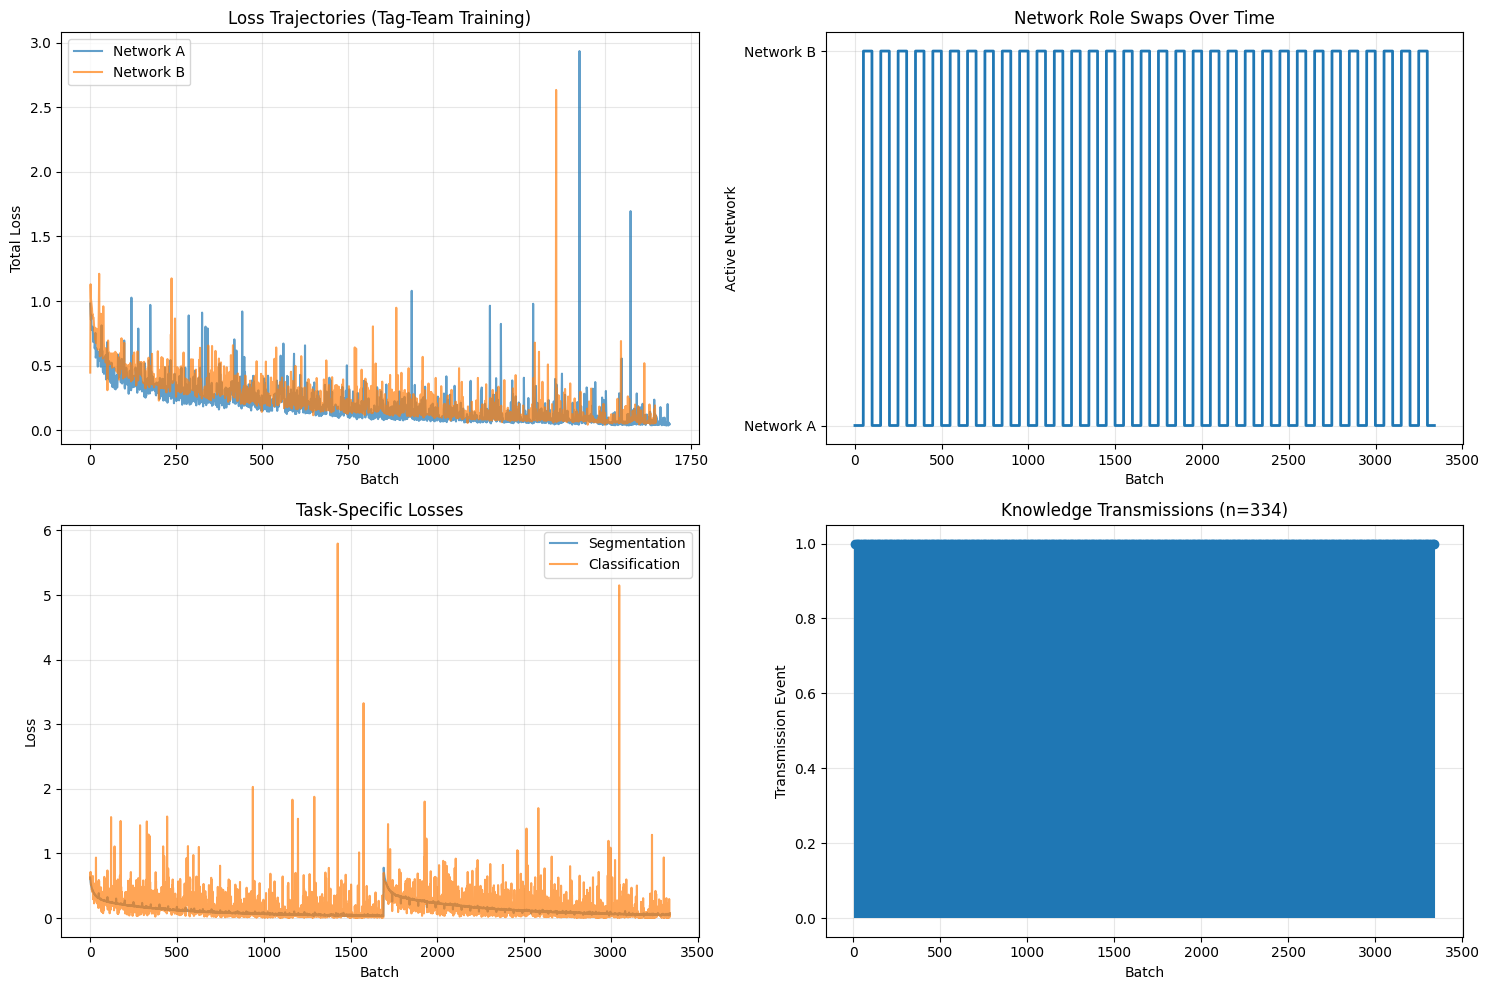

In [9]:
def plot_training_dynamics(trainer: CoDeepNetTrainer):
    """Visualize Co-DeepNet training dynamics"""
    history = trainer.history
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Loss comparison
    ax = axes[0, 0]
    if history['network_a']['total_loss']:
        ax.plot(history['network_a']['total_loss'], label='Network A', alpha=0.7)
    if history['network_b']['total_loss']:
        ax.plot(history['network_b']['total_loss'], label='Network B', alpha=0.7)
    ax.set_xlabel('Batch')
    ax.set_ylabel('Total Loss')
    ax.set_title('Loss Trajectories (Tag-Team Training)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Active network timeline
    ax = axes[0, 1]
    active_encoded = [1 if net == 'A' else 2 for net in history['active_network']]
    ax.plot(active_encoded, linewidth=2)
    ax.set_xlabel('Batch')
    ax.set_ylabel('Active Network')
    ax.set_yticks([1, 2])
    ax.set_yticklabels(['Network A', 'Network B'])
    ax.set_title('Network Role Swaps Over Time')
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Segmentation vs Classification loss
    ax = axes[1, 0]
    all_seg = history['network_a']['seg_loss'] + history['network_b']['seg_loss']
    all_clf = history['network_a']['clf_loss'] + history['network_b']['clf_loss']
    if all_seg:
        ax.plot(all_seg, label='Segmentation', alpha=0.7)
    if all_clf:
        ax.plot(all_clf, label='Classification', alpha=0.7)
    ax.set_xlabel('Batch')
    ax.set_ylabel('Loss')
    ax.set_title('Task-Specific Losses')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Knowledge transmission events
    ax = axes[1, 1]
    if history['transmissions']:
        tx_batches = [t['batch'] for t in history['transmissions']]
        tx_heights = [1] * len(tx_batches)
        ax.stem(tx_batches, tx_heights, basefmt=' ')
        ax.set_xlabel('Batch')
        ax.set_ylabel('Transmission Event')
        ax.set_title(f'Knowledge Transmissions (n={len(tx_batches)})')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_dynamics(codeepnet_trainer)

## 9. Ensemble Prediction & Evaluation

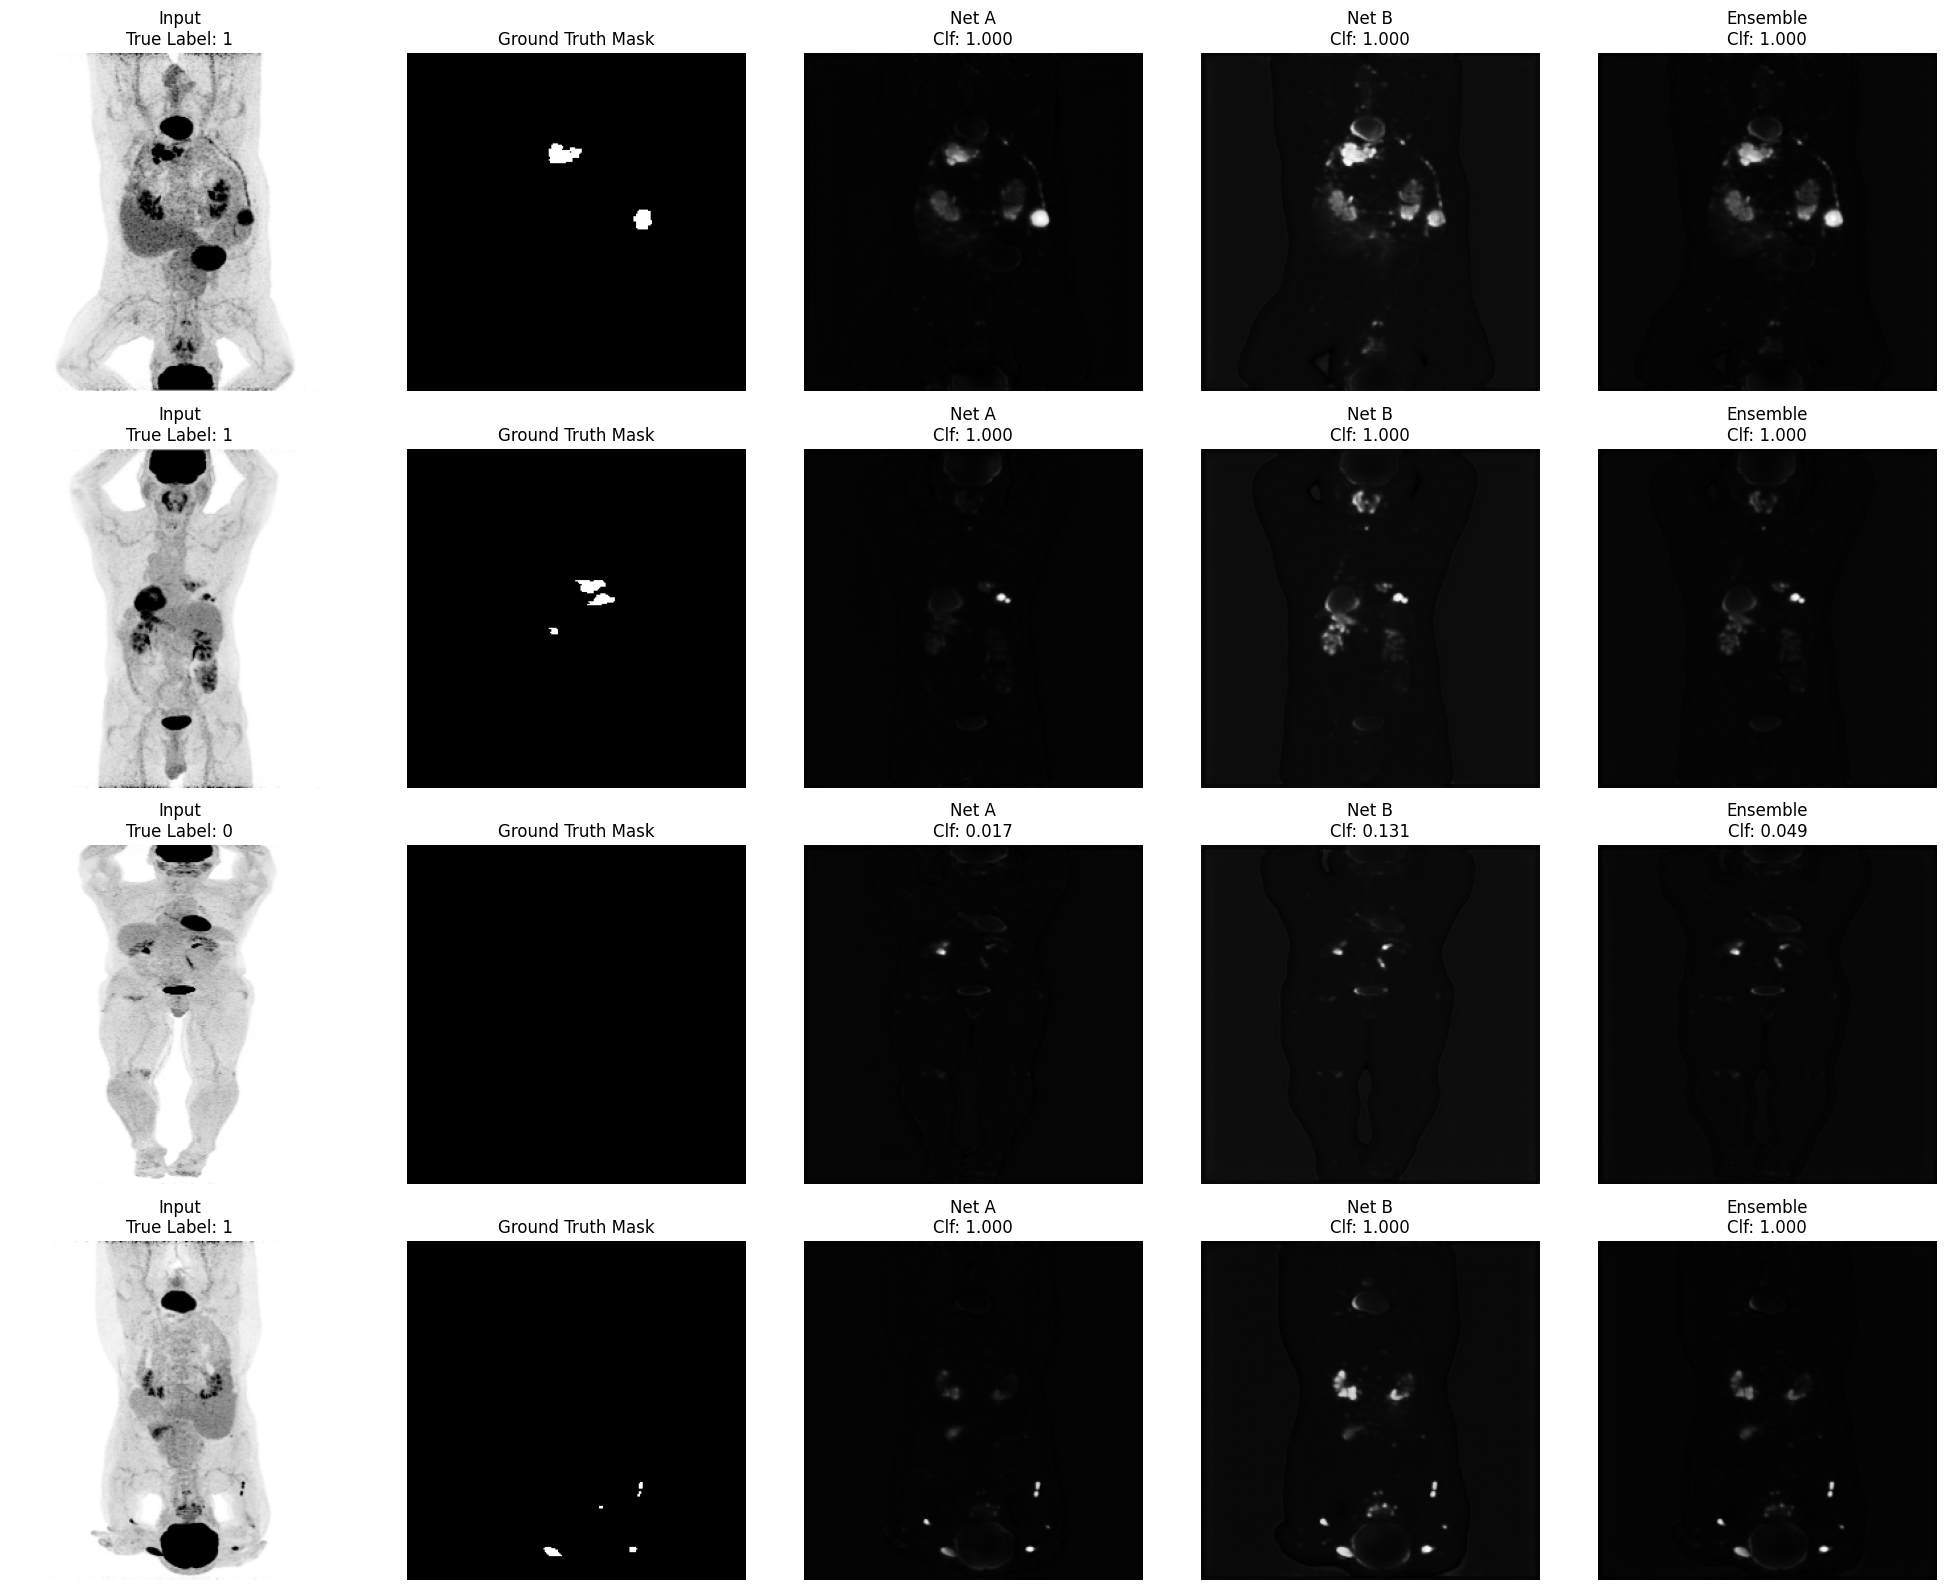

In [10]:
def evaluate_sample(trainer: CoDeepNetTrainer, dataloader: DataLoader, num_samples=4):
    """Visualize ensemble predictions vs individual networks"""
    trainer.unet_a.eval()
    trainer.unet_b.eval()
    
    # Get a batch
    images, masks, clf_labels = next(iter(dataloader))
    images = images[:num_samples]
    masks = masks[:num_samples]
    clf_labels = clf_labels[:num_samples]
    
    # Get predictions
    seg_ensemble, clf_ensemble, (seg_a, clf_a), (seg_b, clf_b) = trainer.predict_ensemble(images)
    
    # Move to CPU for visualization
    images = images.cpu()
    masks = masks.cpu()
    seg_ensemble = seg_ensemble.cpu()
    seg_a = torch.sigmoid(seg_a).cpu()
    seg_b = torch.sigmoid(seg_b).cpu()
    clf_ensemble = clf_ensemble.cpu()
    clf_a = torch.sigmoid(clf_a).cpu()
    clf_b = torch.sigmoid(clf_b).cpu()
    
    # Plot
    fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4*num_samples))
    
    for i in range(num_samples):
        # Original image
        axes[i, 0].imshow(images[i, 0], cmap='gray')
        axes[i, 0].set_title(f'Input\nTrue Label: {clf_labels[i].item()}')
        axes[i, 0].axis('off')
        
        # Ground truth
        axes[i, 1].imshow(masks[i, 0], cmap='gray')
        axes[i, 1].set_title('Ground Truth Mask')
        axes[i, 1].axis('off')
        
        # Network A
        axes[i, 2].imshow(seg_a[i, 0], cmap='gray')
        axes[i, 2].set_title(f'Net A\nClf: {clf_a[i].item():.3f}')
        axes[i, 2].axis('off')
        
        # Network B
        axes[i, 3].imshow(seg_b[i, 0], cmap='gray')
        axes[i, 3].set_title(f'Net B\nClf: {clf_b[i].item():.3f}')
        axes[i, 3].axis('off')
        
        # Ensemble
        axes[i, 4].imshow(seg_ensemble[i, 0], cmap='gray')
        axes[i, 4].set_title(f'Ensemble\nClf: {clf_ensemble[i].item():.3f}')
        axes[i, 4].axis('off')
    
    plt.tight_layout()
    plt.show()

evaluate_sample(codeepnet_trainer, train_loader, num_samples=4)

## 9b. Comprehensive Model Performance Evaluation

This section computes all essential metrics for medical image segmentation and classification:
- **Classification Metrics**: Confusion matrix, accuracy, precision, recall, F1-score, ROC-AUC
- **Segmentation Metrics**: IoU (Jaccard), Dice coefficient, pixel accuracy, sensitivity, specificity
- **Per-Network Comparison**: Individual performance of Network A, Network B, and Ensemble

In [11]:
# Check if model has been trained
print("🔍 Checking Training Status...\n")

training_status = codeepnet_trainer.get_training_summary()

if training_status['total_batches'] == 0:
    print("❌ MODEL NOT TRAINED YET!")
    print("\n⚠️  WARNING: You must run the training loop (Section 7) first!")
    print("   The model currently has random weights and will produce meaningless predictions.\n")
    print("📝 Action Required:")
    print("   1. Scroll up to Section 7: Training Loop")
    print("   2. Run the training cell (it will take several minutes)")
    print("   3. Wait for training to complete (20 epochs)")
    print("   4. Then come back here and run the evaluation\n")
    raise RuntimeError("Training required before evaluation. Please run Section 7 first.")
else:
    print("✅ MODEL HAS BEEN TRAINED!")
    print(f"   • Total training batches: {training_status['total_batches']}")
    print(f"   • Network swaps: {training_status['total_swaps']}")
    print(f"   • Knowledge transmissions: {training_status['total_transmissions']}")
    print(f"   • Network A avg loss: {training_status['avg_loss_a']:.4f}")
    print(f"   • Network B avg loss: {training_status['avg_loss_b']:.4f}")
    print("\n✅ Ready to evaluate! Continue running cells below.\n")

🔍 Checking Training Status...

✅ MODEL HAS BEEN TRAINED!
   • Total training batches: 3340
   • Network swaps: 66
   • Knowledge transmissions: 334
   • Network A avg loss: 0.0730
   • Network B avg loss: 0.0930

✅ Ready to evaluate! Continue running cells below.




🔍 Evaluating on Training Dataset (1336 samples)



Evaluating: 100%|██████████| 167/167 [00:27<00:00,  6.18it/s]
/tmp/ipykernel_7308/1890352526.py:91: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr, fpr)



=======================🎯 SEGMENTATION METRICS ========================

Metric                     Network A       Network B        Ensemble
----------------------------------------------------------------------
IoU                           0.5270          0.4616          0.5084
Dice                          0.6903          0.6316          0.6741
Pixel_Accuracy                0.9953          0.9946          0.9952
Sensitivity                   0.6108          0.5501          0.5859
Specificity                   0.9986          0.9984          0.9987
Precision                     0.7935          0.7415          0.7936

======================🎯 CLASSIFICATION METRICS =======================

Metric                     Network A       Network B        Ensemble
----------------------------------------------------------------------
Accuracy                      0.9843          0.9775          0.9865
Precision                     0.9795          0.9691          0.9816
Recall                

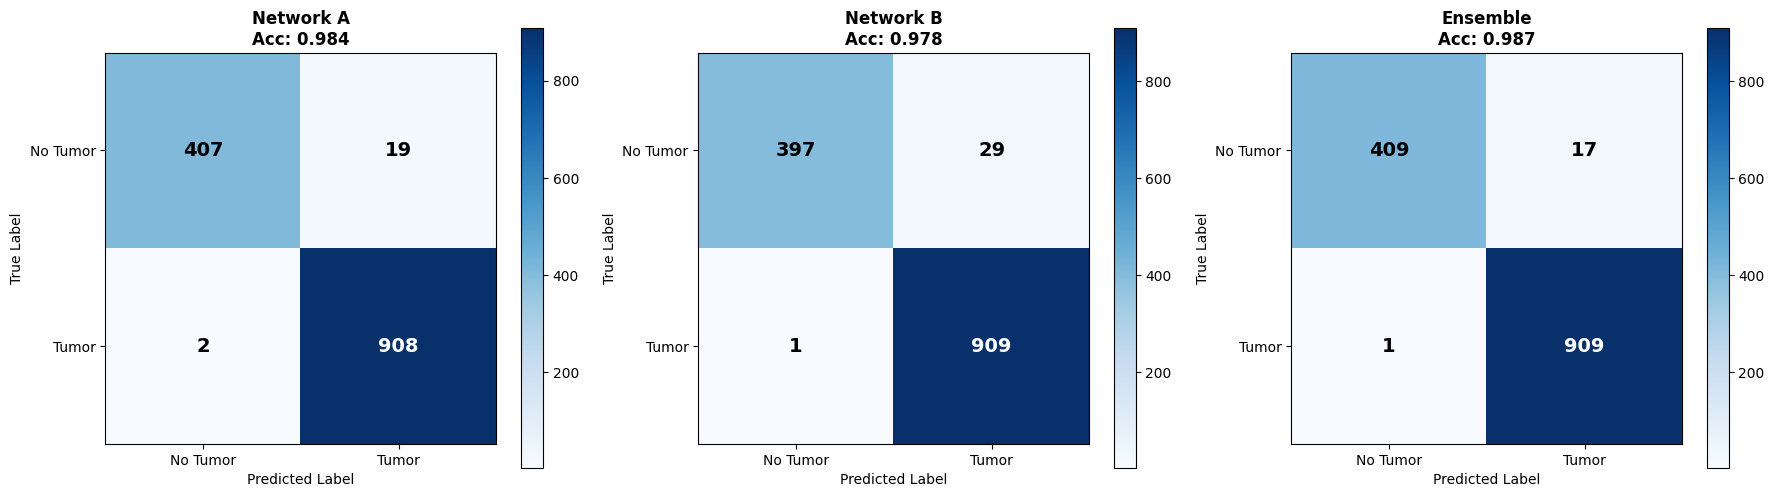


============================📈 ROC CURVES =============================


/tmp/ipykernel_7308/1890352526.py:91: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr, fpr)


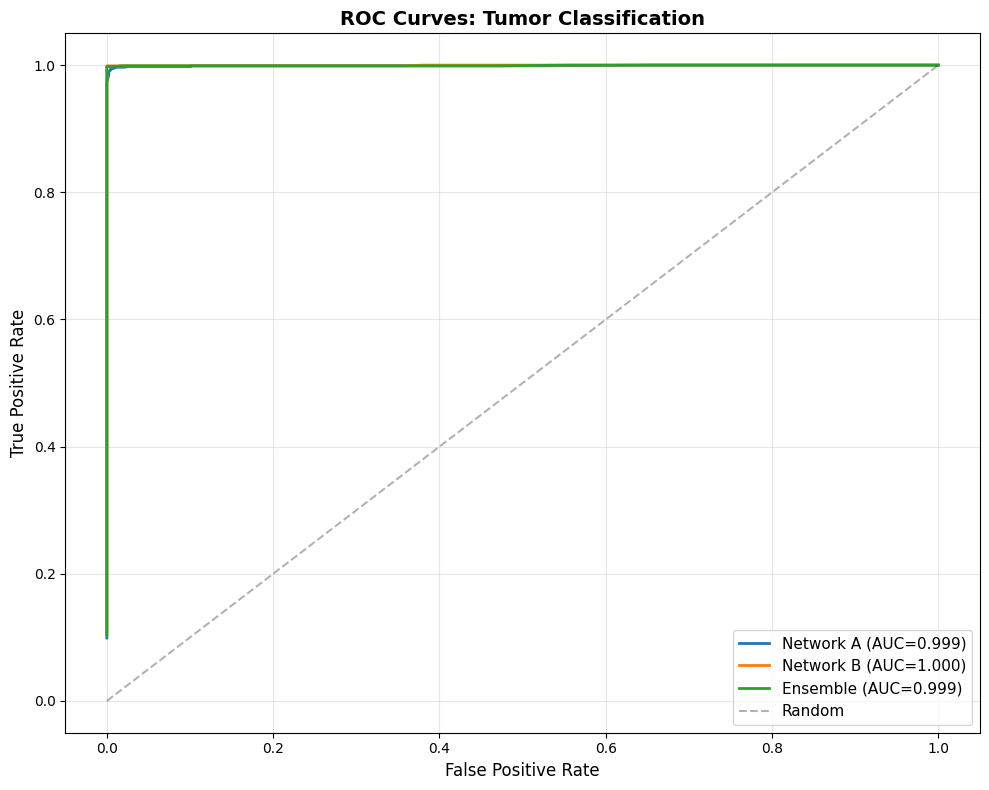


========================📋 PERFORMANCE SUMMARY ========================

🏆 Best Segmentation (Dice): Network A (0.6903)
🏆 Best Classification (F1): Ensemble (0.9902)




In [13]:
def compute_segmentation_metrics(pred_masks, true_masks, threshold=0.5):
    """Compute segmentation metrics manually"""
    pred_binary = (pred_masks > threshold).float()
    true_binary = (true_masks > threshold).float()
    
    pred_flat = pred_binary.view(-1)
    true_flat = true_binary.view(-1)
    
    TP = (pred_flat * true_flat).sum().item()
    FP = (pred_flat * (1 - true_flat)).sum().item()
    FN = ((1 - pred_flat) * true_flat).sum().item()
    TN = ((1 - pred_flat) * (1 - true_flat)).sum().item()
    
    epsilon = 1e-7
    
    iou = TP / (TP + FP + FN + epsilon)
    dice = (2 * TP) / (2 * TP + FP + FN + epsilon)
    pixel_acc = (TP + TN) / (TP + TN + FP + FN + epsilon)
    sensitivity = TP / (TP + FN + epsilon)
    specificity = TN / (TN + FP + epsilon)
    precision = TP / (TP + FP + epsilon)
    
    return {
        'IoU': iou,
        'Dice': dice,
        'Pixel_Accuracy': pixel_acc,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN
    }


def compute_classification_metrics(pred_probs, true_labels, threshold=0.5):
    """Compute classification metrics WITHOUT sklearn"""
    pred_probs_np = pred_probs.cpu().numpy().flatten()
    true_labels_np = true_labels.cpu().numpy().flatten()
    pred_labels = (pred_probs_np > threshold).astype(int)
    
    # Manual confusion matrix
    TP = np.sum((pred_labels == 1) & (true_labels_np == 1))
    TN = np.sum((pred_labels == 0) & (true_labels_np == 0))
    FP = np.sum((pred_labels == 1) & (true_labels_np == 0))
    FN = np.sum((pred_labels == 0) & (true_labels_np == 1))
    
    cm = np.array([[TN, FP], [FN, TP]])
    
    epsilon = 1e-7
    accuracy = (TP + TN) / (TP + TN + FP + FN + epsilon)
    precision = TP / (TP + FP + epsilon)
    recall = TP / (TP + FN + epsilon)
    f1_score = 2 * (precision * recall) / (precision + recall + epsilon)
    
    # Manual ROC-AUC
    roc_auc = compute_roc_auc_manual(true_labels_np, pred_probs_np)
    
    return {
        'Confusion_Matrix': cm,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1_score,
        'ROC_AUC': roc_auc,
        'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN
    }


def compute_roc_auc_manual(y_true, y_scores):
    """Manual ROC-AUC calculation using trapezoidal rule"""
    desc_score_indices = np.argsort(y_scores)[::-1]
    y_scores = y_scores[desc_score_indices]
    y_true = y_true[desc_score_indices]
    
    tps = np.cumsum(y_true)
    fps = np.cumsum(1 - y_true)
    
    total_pos = np.sum(y_true)
    total_neg = len(y_true) - total_pos
    
    if total_pos == 0 or total_neg == 0:
        return 0.0
    
    tpr = tps / total_pos
    fpr = fps / total_neg
    
    tpr = np.concatenate([[0], tpr])
    fpr = np.concatenate([[0], fpr])
    
    auc = np.trapz(tpr, fpr)
    return auc


def plot_confusion_matrix_manual(cm, title, ax):
    """Plot confusion matrix without seaborn"""
    im = ax.imshow(cm, cmap='Blues', interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['No Tumor', 'Tumor'])
    ax.set_yticklabels(['No Tumor', 'Tumor'])
    
    # Add text annotations
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, int(cm[i, j]),
                          ha="center", va="center",
                          color="white" if cm[i, j] > cm.max()/2 else "black",
                          fontsize=14, fontweight='bold')
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=10)
    ax.set_xlabel('Predicted Label', fontsize=10)


def evaluate_full_dataset(trainer, dataloader, dataset_name='Train'):
    """Comprehensive evaluation WITHOUT sklearn"""
    print(f"\n{'='*70}")
    print(f"🔍 Evaluating on {dataset_name} Dataset ({len(dataloader.dataset)} samples)")
    print(f"{'='*70}\n")
    
    trainer.unet_a.eval()
    trainer.unet_b.eval()
    
    # Collect predictions
    all_seg_preds_a, all_seg_preds_b, all_seg_preds_ensemble = [], [], []
    all_seg_true = []
    all_clf_preds_a, all_clf_preds_b, all_clf_preds_ensemble = [], [], []
    all_clf_true = []
    
    with torch.no_grad():
        for images, masks, clf_labels in tqdm(dataloader, desc="Evaluating"):
            images = images.to(trainer.device)
            
            seg_a, clf_a = trainer.unet_a(images)
            seg_b, clf_b = trainer.unet_b(images)
            
            seg_ensemble = (seg_a + seg_b) / 2
            clf_ensemble = (clf_a + clf_b) / 2
            
            all_seg_preds_a.append(torch.sigmoid(seg_a).cpu())
            all_seg_preds_b.append(torch.sigmoid(seg_b).cpu())
            all_seg_preds_ensemble.append(torch.sigmoid(seg_ensemble).cpu())
            all_seg_true.append(masks.cpu())
            
            all_clf_preds_a.append(torch.sigmoid(clf_a).cpu())
            all_clf_preds_b.append(torch.sigmoid(clf_b).cpu())
            all_clf_preds_ensemble.append(torch.sigmoid(clf_ensemble).cpu())
            all_clf_true.append(clf_labels.cpu())
    
    # Concatenate
    seg_preds_a = torch.cat(all_seg_preds_a, dim=0)
    seg_preds_b = torch.cat(all_seg_preds_b, dim=0)
    seg_preds_ensemble = torch.cat(all_seg_preds_ensemble, dim=0)
    seg_true = torch.cat(all_seg_true, dim=0)
    
    clf_preds_a = torch.cat(all_clf_preds_a, dim=0)
    clf_preds_b = torch.cat(all_clf_preds_b, dim=0)
    clf_preds_ensemble = torch.cat(all_clf_preds_ensemble, dim=0)
    clf_true = torch.cat(all_clf_true, dim=0)
    
    # Compute metrics
    seg_metrics_a = compute_segmentation_metrics(seg_preds_a, seg_true)
    seg_metrics_b = compute_segmentation_metrics(seg_preds_b, seg_true)
    seg_metrics_ensemble = compute_segmentation_metrics(seg_preds_ensemble, seg_true)
    
    clf_metrics_a = compute_classification_metrics(clf_preds_a, clf_true)
    clf_metrics_b = compute_classification_metrics(clf_preds_b, clf_true)
    clf_metrics_ensemble = compute_classification_metrics(clf_preds_ensemble, clf_true)
    
    # Print segmentation metrics
    print("\n" + "🎯 SEGMENTATION METRICS ".center(70, "="))
    print(f"\n{'Metric':<20} {'Network A':>15} {'Network B':>15} {'Ensemble':>15}")
    print("-" * 70)
    for metric in ['IoU', 'Dice', 'Pixel_Accuracy', 'Sensitivity', 'Specificity', 'Precision']:
        print(f"{metric:<20} {seg_metrics_a[metric]:>15.4f} {seg_metrics_b[metric]:>15.4f} {seg_metrics_ensemble[metric]:>15.4f}")
    
    # Print classification metrics
    print("\n" + "🎯 CLASSIFICATION METRICS ".center(70, "="))
    print(f"\n{'Metric':<20} {'Network A':>15} {'Network B':>15} {'Ensemble':>15}")
    print("-" * 70)
    for metric in ['Accuracy', 'Precision', 'Recall', 'F1_Score', 'ROC_AUC']:
        print(f"{metric:<20} {clf_metrics_a[metric]:>15.4f} {clf_metrics_b[metric]:>15.4f} {clf_metrics_ensemble[metric]:>15.4f}")
    
    # Plot confusion matrices
    print("\n" + "📊 CONFUSION MATRICES ".center(70, "="))
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    plot_confusion_matrix_manual(clf_metrics_a['Confusion_Matrix'], 
                                f"Network A\nAcc: {clf_metrics_a['Accuracy']:.3f}", axes[0])
    plot_confusion_matrix_manual(clf_metrics_b['Confusion_Matrix'],
                                f"Network B\nAcc: {clf_metrics_b['Accuracy']:.3f}", axes[1])
    plot_confusion_matrix_manual(clf_metrics_ensemble['Confusion_Matrix'],
                                f"Ensemble\nAcc: {clf_metrics_ensemble['Accuracy']:.3f}", axes[2])
    
    plt.tight_layout()
    plt.show()
    
    # Plot ROC curves
    print("\n" + "📈 ROC CURVES ".center(70, "="))
    
    clf_true_np = clf_true.numpy().flatten()
    clf_preds_a_np = clf_preds_a.numpy().flatten()
    clf_preds_b_np = clf_preds_b.numpy().flatten()
    clf_preds_ens_np = clf_preds_ensemble.numpy().flatten()
    
    if len(np.unique(clf_true_np)) > 1:
        plt.figure(figsize=(10, 8))
        
        # Manual ROC curve calculation
        for name, preds, color in [('Network A', clf_preds_a_np, '#1f77b4'),
                                     ('Network B', clf_preds_b_np, '#ff7f0e'),
                                     ('Ensemble', clf_preds_ens_np, '#2ca02c')]:
            thresholds = np.linspace(1, 0, 100)
            tpr_list, fpr_list = [], []
            
            for thresh in thresholds:
                pred_labels = (preds >= thresh).astype(int)
                TP = np.sum((pred_labels == 1) & (clf_true_np == 1))
                TN = np.sum((pred_labels == 0) & (clf_true_np == 0))
                FP = np.sum((pred_labels == 1) & (clf_true_np == 0))
                FN = np.sum((pred_labels == 0) & (clf_true_np == 1))
                
                tpr = TP / (TP + FN + 1e-7)
                fpr = FP / (FP + TN + 1e-7)
                tpr_list.append(tpr)
                fpr_list.append(fpr)
            
            auc = compute_roc_auc_manual(clf_true_np, preds)
            plt.plot(fpr_list, tpr_list, label=f'{name} (AUC={auc:.3f})', 
                    linewidth=2, color=color)
        
        plt.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random', linewidth=1.5)
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('ROC Curves: Tumor Classification', fontsize=14, fontweight='bold')
        plt.legend(loc='lower right', fontsize=11)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Summary
    print("\n" + "📋 PERFORMANCE SUMMARY ".center(70, "="))
    best_dice = max(seg_metrics_a['Dice'], seg_metrics_b['Dice'], seg_metrics_ensemble['Dice'])
    best_f1 = max(clf_metrics_a['F1_Score'], clf_metrics_b['F1_Score'], clf_metrics_ensemble['F1_Score'])
    
    print(f"\n🏆 Best Segmentation (Dice): ", end="")
    if seg_metrics_ensemble['Dice'] == best_dice:
        print(f"Ensemble ({seg_metrics_ensemble['Dice']:.4f})")
    elif seg_metrics_a['Dice'] == best_dice:
        print(f"Network A ({seg_metrics_a['Dice']:.4f})")
    else:
        print(f"Network B ({seg_metrics_b['Dice']:.4f})")
    
    print(f"🏆 Best Classification (F1): ", end="")
    if clf_metrics_ensemble['F1_Score'] == best_f1:
        print(f"Ensemble ({clf_metrics_ensemble['F1_Score']:.4f})")
    elif clf_metrics_a['F1_Score'] == best_f1:
        print(f"Network A ({clf_metrics_a['F1_Score']:.4f})")
    else:
        print(f"Network B ({clf_metrics_b['F1_Score']:.4f})")
    
    print("\n" + "="*70 + "\n")
    
    return {
        'segmentation': {
            'network_a': seg_metrics_a,
            'network_b': seg_metrics_b,
            'ensemble': seg_metrics_ensemble
        },
        'classification': {
            'network_a': clf_metrics_a,
            'network_b': clf_metrics_b,
            'ensemble': clf_metrics_ensemble
        }
    }


# Run evaluation
evaluation_results = evaluate_full_dataset(codeepnet_trainer, train_loader, dataset_name='Training')

## 9c. Detailed Performance Analysis & Error Cases

Analyze where the model performs well and where it struggles.


=======================🔍 QUALITATIVE ANALYSIS ========================

Finding best and worst predictions...

✅ TOP 3 BEST PREDICTIONS (Highest Dice Scores)


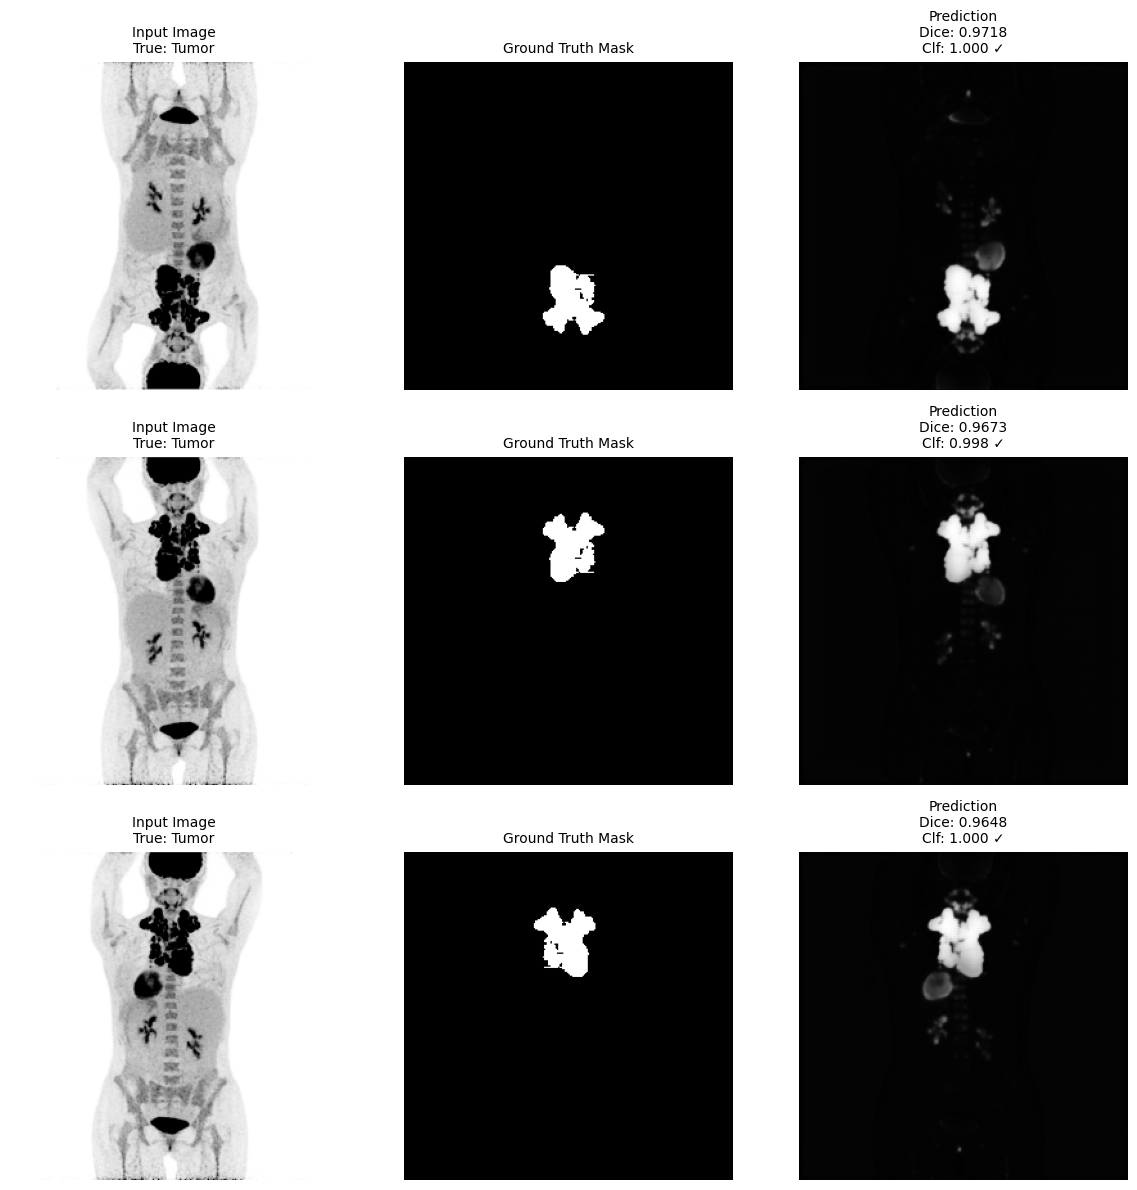


❌ TOP 3 WORST PREDICTIONS (Lowest Dice Scores)


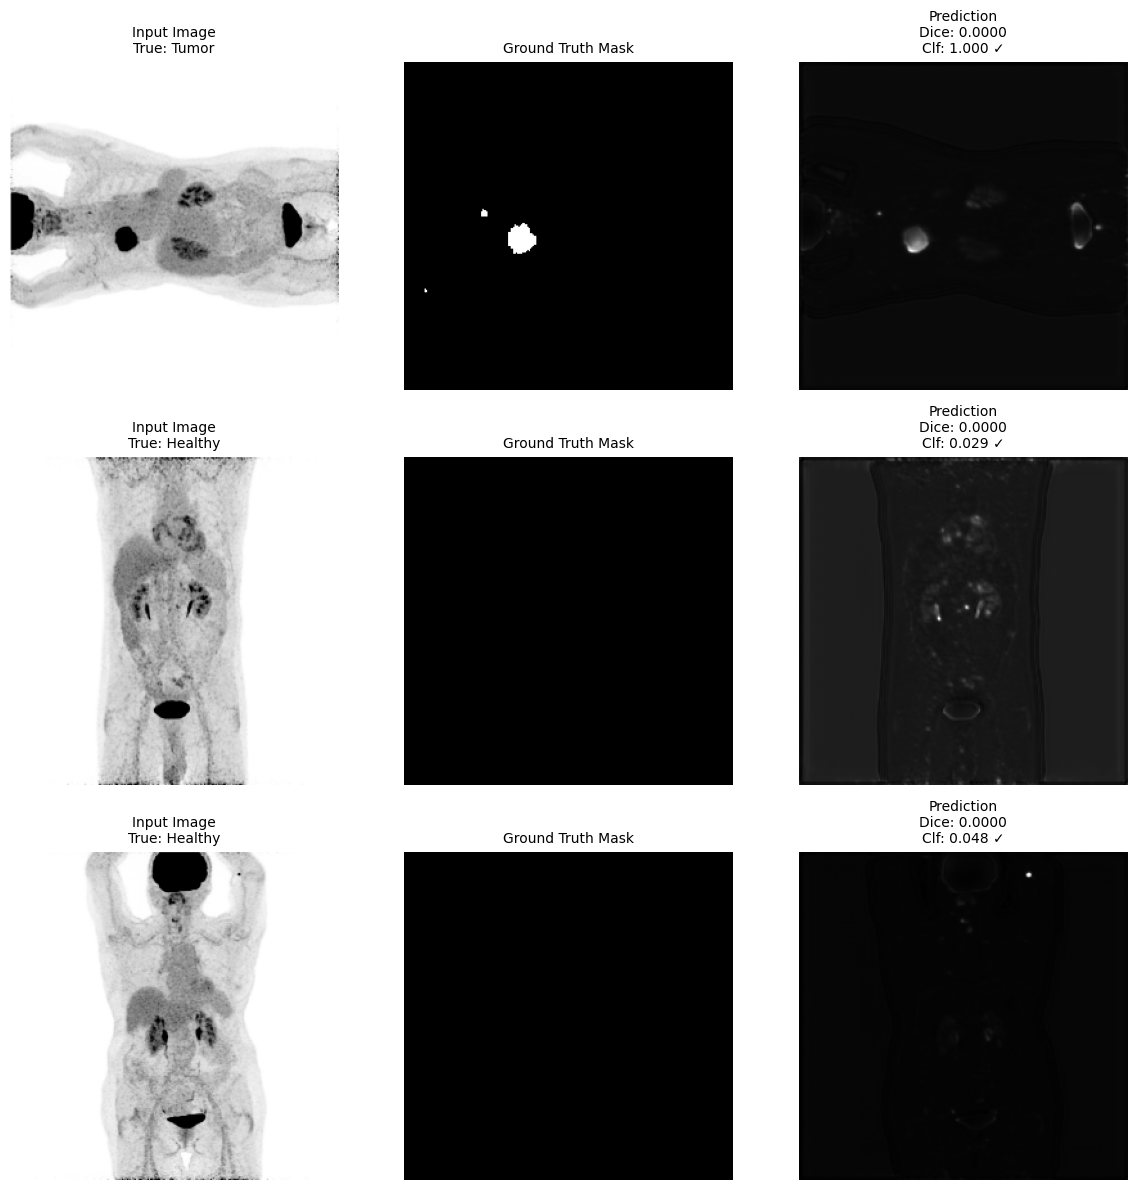


📊 STATISTICS:
  Mean Dice Score: 0.3681 ± 0.3425
  Median Dice Score: 0.3424
  Min Dice Score: 0.0000
  Max Dice Score: 0.9718
  Classification Accuracy: 0.9865 (1318/1336)



In [14]:
def analyze_best_and_worst_cases(trainer: CoDeepNetTrainer, dataloader: DataLoader, num_samples=3):
    """
    Visualize best and worst predictions to understand model behavior.
    """
    print("\n" + "🔍 QUALITATIVE ANALYSIS ".center(70, "="))
    print("\nFinding best and worst predictions...\n")
    
    trainer.unet_a.eval()
    trainer.unet_b.eval()
    
    # Collect all samples with their metrics
    all_samples = []
    
    with torch.no_grad():
        for images, masks, clf_labels in dataloader:
            images_device = images.to(trainer.device)
            
            # Get ensemble predictions
            seg_ensemble, clf_ensemble, _, _ = trainer.predict_ensemble(images_device)
            
            # Compute per-sample Dice scores
            for i in range(images.size(0)):
                seg_pred = seg_ensemble[i:i+1].cpu()
                seg_true = masks[i:i+1]
                
                # Compute Dice score
                pred_binary = (seg_pred > 0.5).float()
                true_binary = (seg_true > 0.5).float()
                
                intersection = (pred_binary * true_binary).sum().item()
                union = pred_binary.sum().item() + true_binary.sum().item()
                dice = (2 * intersection) / (union + 1e-7)
                
                # Classification correctness
                clf_pred_class = (clf_ensemble[i].cpu() > 0.5).long().item()
                clf_true_class = clf_labels[i].item()
                clf_correct = (clf_pred_class == clf_true_class)
                
                all_samples.append({
                    'image': images[i],
                    'mask': masks[i],
                    'seg_pred': seg_pred[0],
                    'clf_pred': clf_ensemble[i].cpu().item(),
                    'clf_true': clf_true_class,
                    'dice': dice,
                    'clf_correct': clf_correct
                })
    
    # Sort by Dice score
    all_samples.sort(key=lambda x: x['dice'], reverse=True)
    
    # Get best and worst cases
    best_samples = all_samples[:num_samples]
    worst_samples = all_samples[-num_samples:]
    
    # Visualize best cases
    print(f"✅ TOP {num_samples} BEST PREDICTIONS (Highest Dice Scores)")
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i, sample in enumerate(best_samples):
        axes[i, 0].imshow(sample['image'][0], cmap='gray')
        axes[i, 0].set_title(f"Input Image\nTrue: {'Tumor' if sample['clf_true'] else 'Healthy'}", fontsize=10)
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(sample['mask'][0], cmap='gray')
        axes[i, 1].set_title('Ground Truth Mask', fontsize=10)
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(sample['seg_pred'][0], cmap='gray')
        axes[i, 2].set_title(f"Prediction\nDice: {sample['dice']:.4f}\nClf: {sample['clf_pred']:.3f} {'✓' if sample['clf_correct'] else '✗'}", fontsize=10)
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Visualize worst cases
    print(f"\n❌ TOP {num_samples} WORST PREDICTIONS (Lowest Dice Scores)")
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i, sample in enumerate(worst_samples):
        axes[i, 0].imshow(sample['image'][0], cmap='gray')
        axes[i, 0].set_title(f"Input Image\nTrue: {'Tumor' if sample['clf_true'] else 'Healthy'}", fontsize=10)
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(sample['mask'][0], cmap='gray')
        axes[i, 1].set_title('Ground Truth Mask', fontsize=10)
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(sample['seg_pred'][0], cmap='gray')
        axes[i, 2].set_title(f"Prediction\nDice: {sample['dice']:.4f}\nClf: {sample['clf_pred']:.3f} {'✓' if sample['clf_correct'] else '✗'}", fontsize=10)
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    dice_scores = [s['dice'] for s in all_samples]
    clf_accuracy = sum([s['clf_correct'] for s in all_samples]) / len(all_samples)
    
    print(f"\n📊 STATISTICS:")
    print(f"  Mean Dice Score: {np.mean(dice_scores):.4f} ± {np.std(dice_scores):.4f}")
    print(f"  Median Dice Score: {np.median(dice_scores):.4f}")
    print(f"  Min Dice Score: {np.min(dice_scores):.4f}")
    print(f"  Max Dice Score: {np.max(dice_scores):.4f}")
    print(f"  Classification Accuracy: {clf_accuracy:.4f} ({int(clf_accuracy*len(all_samples))}/{len(all_samples)})")
    print("="*70 + "\n")


# Run qualitative analysis
analyze_best_and_worst_cases(codeepnet_trainer, train_loader, num_samples=3)